In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import logging
from pathlib import Path

import arviz as az
import numpyro

from hb_mep.config import HBMepConfig
from hb_mep.data_access import DataClass
# from hb_mep.models.rats import MixtureModel
from hb_mep.models.rats.utils import load_data
from hb_mep.utils import plot

numpyro.set_platform("cpu")
numpyro.set_host_device_count(12)
numpyro.enable_x64()

PARENT_PATH = Path(os.getcwd()).parent.parent.absolute()
FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)


import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd

import numpyro
import numpyro.distributions as dist
from numpyro.distributions.mixtures import MixtureGeneral
from numpyro.infer import MCMC, NUTS
from numpyro.diagnostics import hpdi

from hb_mep.config import HBMepConfig
from hb_mep.models.baseline import Baseline
from hb_mep.models.utils import Site as site
from hb_mep.utils import timing
from hb_mep.utils.constants import (
    INTENSITY,
    RESPONSE,
    PARTICIPANT,
    FEATURES
)

logger = logging.getLogger(__name__)

#### Load config

In [3]:
config = HBMepConfig()
config.CURRENT_PATH = PARENT_PATH

#### Load data and preprocess

In [4]:
data = DataClass(config)

a, b = 2, 3
subset = range(a, b)

df, mat, time = load_data(subset, data)
df, encoder_dict = data.build(df)


2023-06-10 20:55:05,318 - hb_mep.utils.utils - INFO - func:load_data took: 0.13 sec
2023-06-10 20:55:05,319 - hb_mep.data_access.core - INFO - Processing data ...
2023-06-10 20:55:05,326 - hb_mep.utils.utils - INFO - func:preprocess took: 0.01 sec
2023-06-10 20:55:05,326 - hb_mep.utils.utils - INFO - func:build took: 0.01 sec


### Mixture Model

In [5]:
class MixtureModel(Baseline):
    def __init__(self, config: HBMepConfig):
        super(MixtureModel, self).__init__(config=config)
        self.name = "Mixture_Model"

        self.columns = [PARTICIPANT] + FEATURES
        self.x = np.linspace(0, 450, 1000)

    def _model(self, intensity, participant, feature0, feature1, response_obs=None):
        n_data = intensity.shape[0]
        n_participant = np.unique(participant).shape[0]
        n_feature0 = np.unique(feature0).shape[0]
        n_feature1 = np.unique(feature1).shape[0]

        with numpyro.plate("n_participant", n_participant, dim=-1):
            """ Hyper-priors """
            a_mean = numpyro.sample(
                site.a_mean,
                dist.TruncatedNormal(200, 50, low=0)
            )
            a_scale = numpyro.sample(site.a_scale, dist.HalfNormal(20))

            b_scale = numpyro.sample(site.b_scale, dist.HalfNormal(0.1))

            h_mean = numpyro.sample(
                "h_mean",
                dist.TruncatedNormal(5, 1, low=0)
            )
            h_scale = numpyro.sample("h_scale", dist.HalfNormal(2))

            v_scale = numpyro.sample("v_scale", dist.HalfNormal(10))

            lo_scale = numpyro.sample(site.lo_scale, dist.HalfNormal(0.05))

            noise_offset_scale = numpyro.sample(
                site.noise_offset_scale,
                dist.HalfCauchy(0.005)
            )
            noise_slope_scale = numpyro.sample(
                site.noise_slope_scale,
                dist.HalfCauchy(0.005)
            )

            # noise_mixture_scale = numpyro.sample(
            #     "noise_mixture_scale",
            #     dist.HalfCauchy(0.0001)
            # )

            with numpyro.plate("n_feature0", n_feature0, dim=-2):
                with numpyro.plate("n_feature1", n_feature1, dim=-3):
                    """ Priors """
                    a = numpyro.sample(
                        site.a,
                        dist.TruncatedNormal(a_mean, a_scale, low=0)
                    )
                    # b = numpyro.sample(site.b, dist.HalfNormal(b_scale))
                    b = numpyro.sample(site.b, dist.Uniform(0.1, 0.5))

                    h = numpyro.sample(
                        "h",
                        dist.TruncatedNormal(h_mean, h_scale, low=0)
                    )

                    v = numpyro.sample("v", dist.HalfNormal(v_scale))

                    lo = numpyro.sample(site.lo, dist.HalfNormal(lo_scale))

                    noise_offset = numpyro.sample(
                        site.noise_offset,
                        dist.HalfCauchy(noise_offset_scale)
                    )
                    noise_slope = numpyro.sample(
                        site.noise_slope,
                        dist.HalfCauchy(noise_slope_scale)
                    )

                    # noise_mixture = numpyro.sample(
                    #     "noise_mixture",
                    #     dist.HalfCauchy(noise_mixture_scale)
                    # )

                    q = numpyro.sample("q", dist.Beta(2, 24))

        """ Model """
        mean = numpyro.deterministic(
            site.mean,
            lo[feature1, feature0, participant] + \
            jnp.maximum(
                0,
                -1 + \
                (h[feature1, feature0, participant] + 1) / \
                jnp.power(
                    1 + \
                    (jnp.power(1 + h[feature1, feature0, participant], v[feature1, feature0, participant]) - 1) * \
                    jnp.exp(-b[feature1, feature0, participant] * (intensity - a[feature1, feature0, participant])),
                    1 / v[feature1, feature0, participant]
                )
            )
        )

        sigma = numpyro.deterministic(
            "sigma",
            noise_offset[feature1, feature0, participant] + \
            noise_slope[feature1, feature0, participant] * jnp.power(mean, .5)
        )

        """ Mixture """
        fg_dist = dist.TruncatedNormal(mean, sigma, low=0)
        # bg_dist = dist.TruncatedNormal(
        #     h[feature1, feature0, participant] / 2, noise_mixture[feature1, feature0, participant], low=0
        # )
        bg_dist = dist.TruncatedNormal(mean, 50, low=0)

        # bg_mean = numpyro.sample("bg_mean", dist.TruncatedNormal(2, 1.0))
        # bg_sigma = numpyro.sample("bg_sigma", dist.HalfNormal(3.0))
        # bg_dist = dist.Normal(bg_mean, jnp.sqrt(bg_sigma**2 + yerr**2))

        component_distributions = [fg_dist, bg_dist]

        mixing_distribution = dist.Categorical(
            probs=jnp.array([1 - q[feature1, feature0, participant], q[feature1, feature0, participant]]).T
        )

        mixture = MixtureGeneral(
            component_distributions=component_distributions,
            mixing_distribution=mixing_distribution
        )

        """ Observation """
        with numpyro.plate(site.data, n_data):
            return numpyro.sample(site.obs, mixture, obs=response_obs)
            # return numpyro.sample(site.obs, fg_dist, obs=response_obs)

    @timing
    def run_inference(self, df: pd.DataFrame) -> tuple[numpyro.infer.mcmc.MCMC, dict]:
        """
        Run MCMC inference
        """
        response = df[RESPONSE].to_numpy().reshape(-1,)
        participant = df[PARTICIPANT].to_numpy().reshape(-1,)
        feature0 = df[FEATURES[0]].to_numpy().reshape(-1,)
        feature1 = df[FEATURES[1]].to_numpy().reshape(-1,)
        intensity = df[INTENSITY].to_numpy().reshape(-1,)

        # MCMC
        nuts_kernel = NUTS(self._model)
        mcmc = MCMC(nuts_kernel, **self.config.MCMC_PARAMS)
        rng_key = jax.random.PRNGKey(self.random_state)
        logger.info(f"Running inference with {self.name} ...")
        mcmc.run(rng_key, intensity, participant, feature0, feature1, response)
        posterior_samples = mcmc.get_samples()

        return mcmc, posterior_samples



#### Initialize model

ValueError: All component distributions must have the same support.

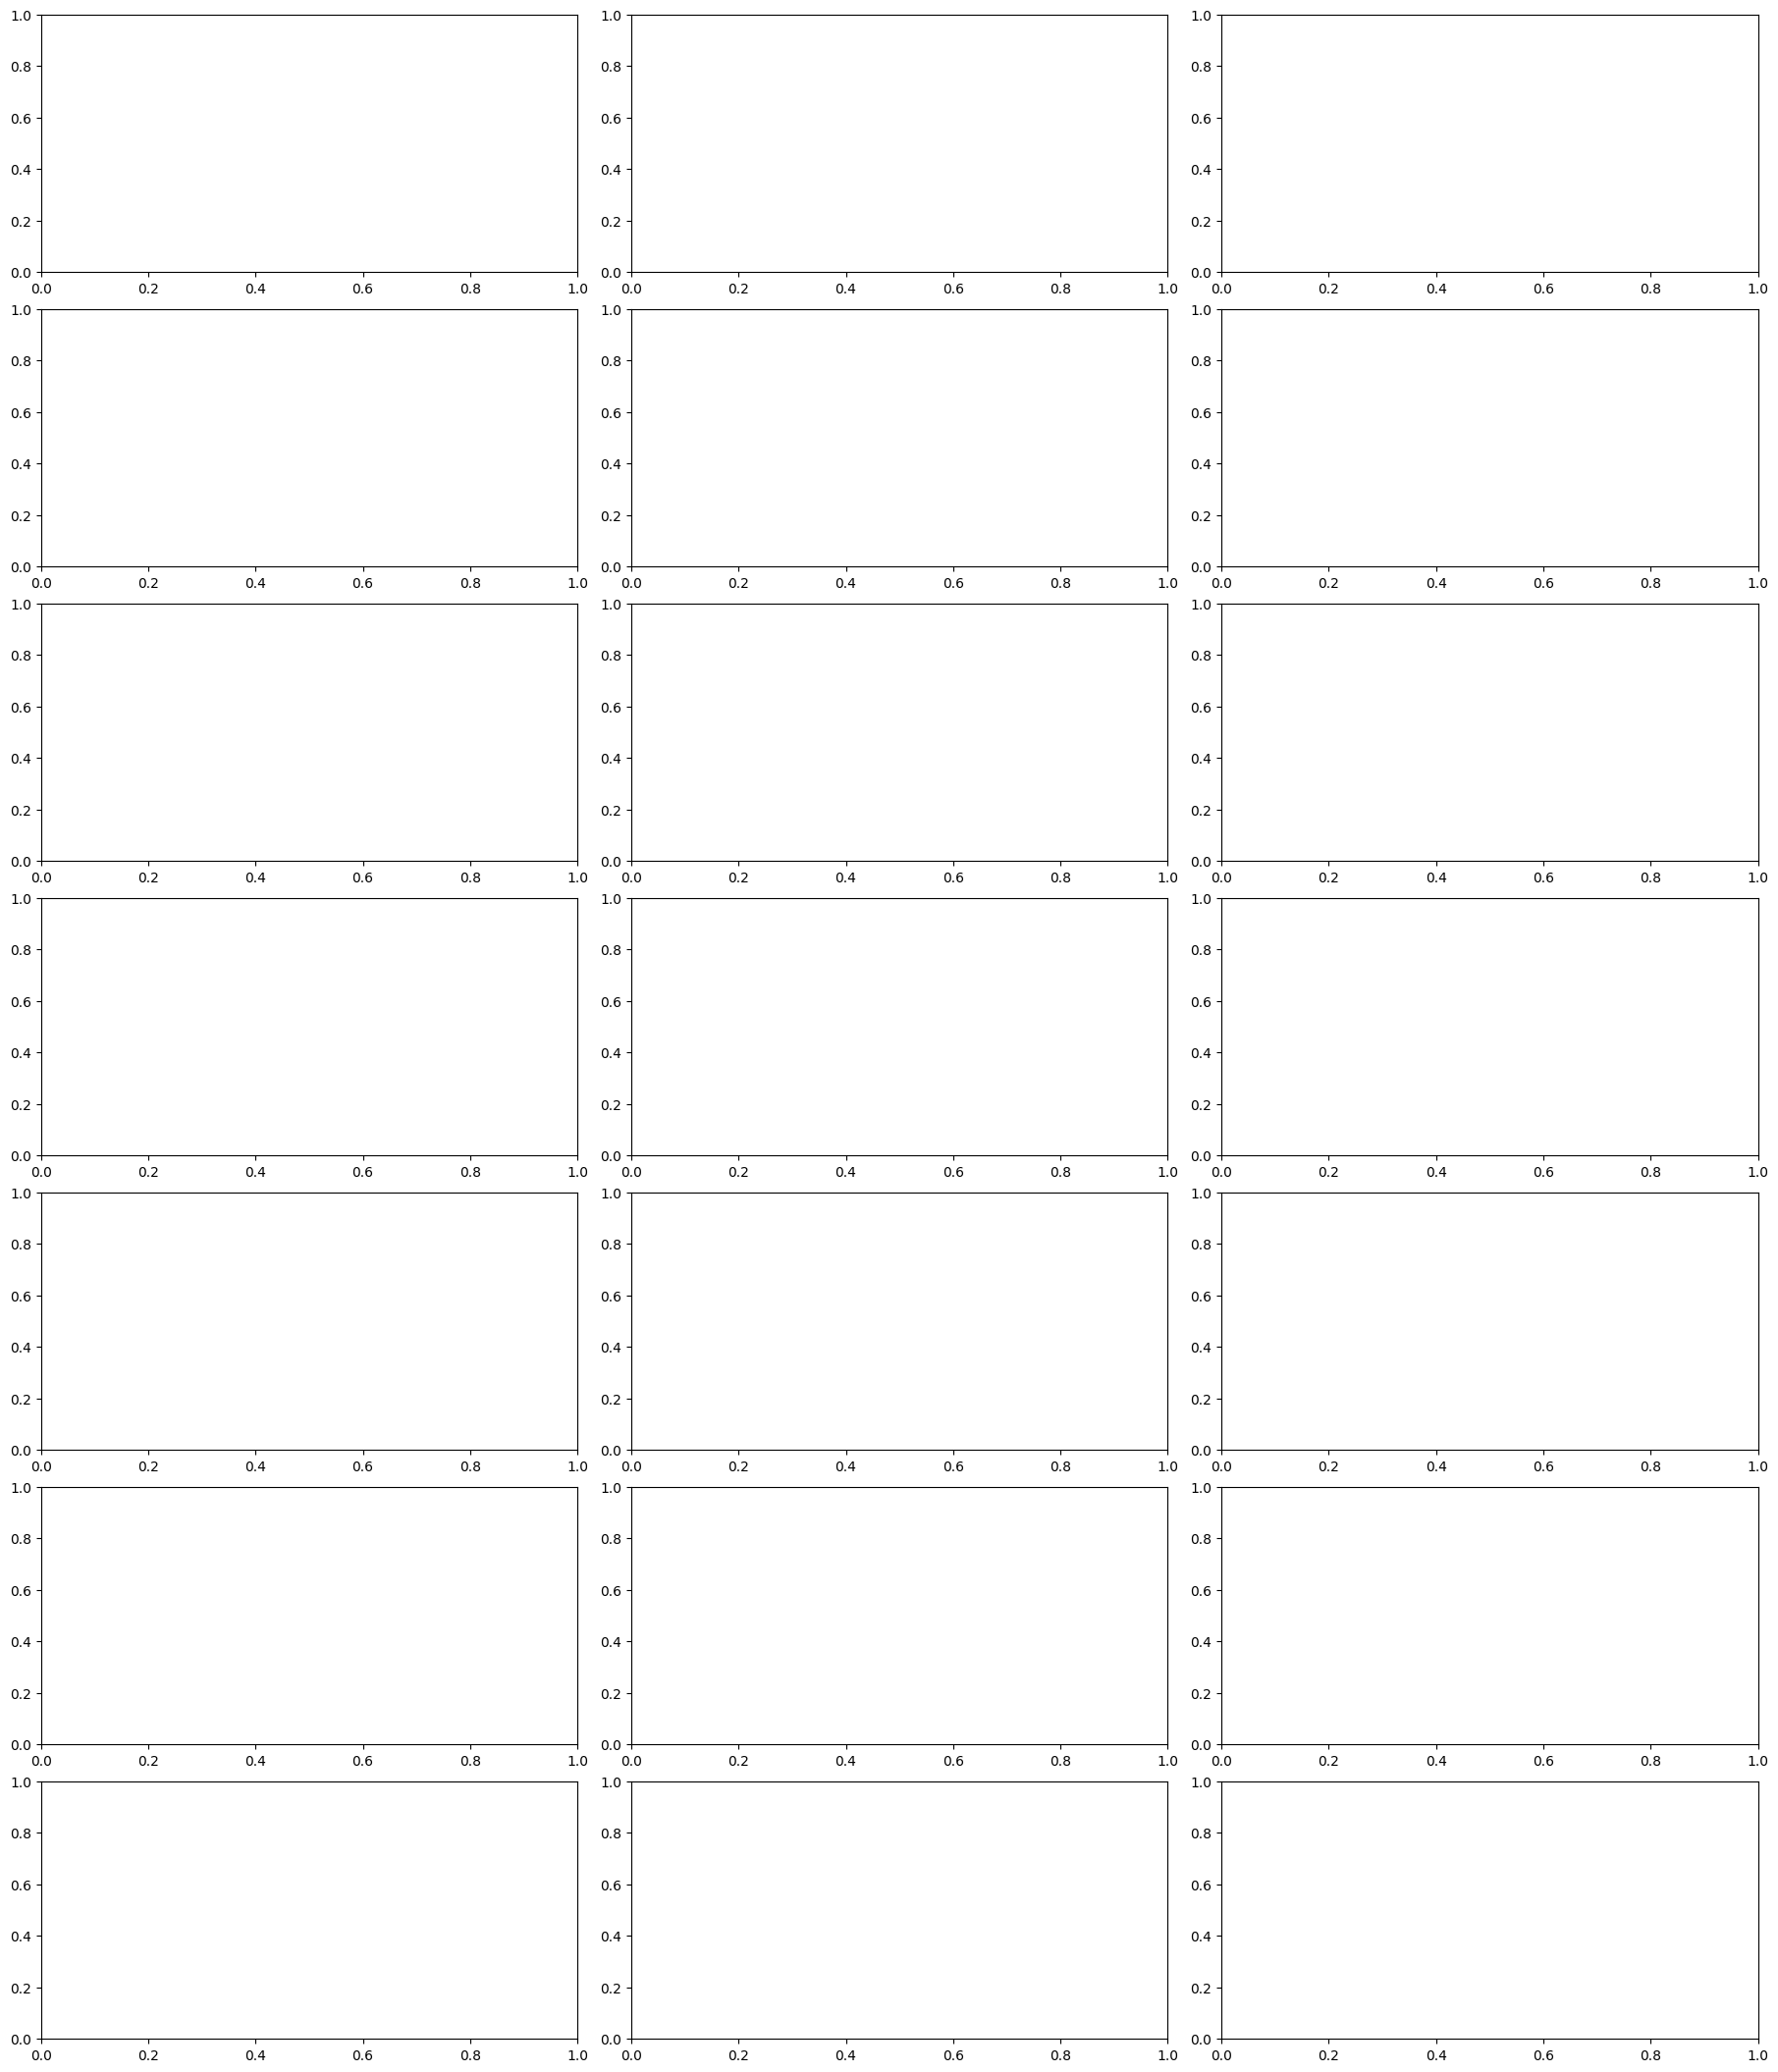

In [7]:
model = MixtureModel(config)

model.predictive_check(df=df, n_ppdm=1000, n_ppdo=1);

#### Run MCMC inference

In [7]:
mcmc, posterior_samples = model.run_inference(df=df)

2023-06-10 20:33:18,581 - __main__ - INFO - Running inference with Mixture_Model ...


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-06-10 20:43:06,415 - hb_mep.utils.utils - INFO - func:run_inference took: 9 min and 47.84 sec


#### Diagnostics

In [10]:
mcmc.print_summary(prob=.95)


                           mean       std    median      2.5%     97.5%     n_eff     r_hat
             a[0,0,0]     45.44      1.47     45.60     42.42     47.90   4648.28      1.00
             a[0,1,0]    117.83      5.10    118.69    107.48    126.84   5583.93      1.00
             a[0,2,0]    221.89      4.67    222.80    212.33    228.67    847.03      1.00
             a[0,3,0]    224.08      8.35    224.33    207.30    240.36   5216.32      1.00
             a[1,0,0]    201.60      3.61    201.81    194.94    209.00   2257.15      1.00
             a[1,1,0]    178.89     54.19    178.33     70.46    284.82   9348.61      1.00
             a[1,2,0]    198.96      7.74    196.06    188.02    209.74    586.18      1.01
             a[1,3,0]    213.76     11.63    215.35    194.39    230.24   1097.43      1.00
            a_mean[0]    178.13     18.22    177.93    141.63    213.80   9330.45      1.00
           a_scale[0]     50.89      8.66     50.02     35.22     68.49  10628.

#### Plot fitted curves

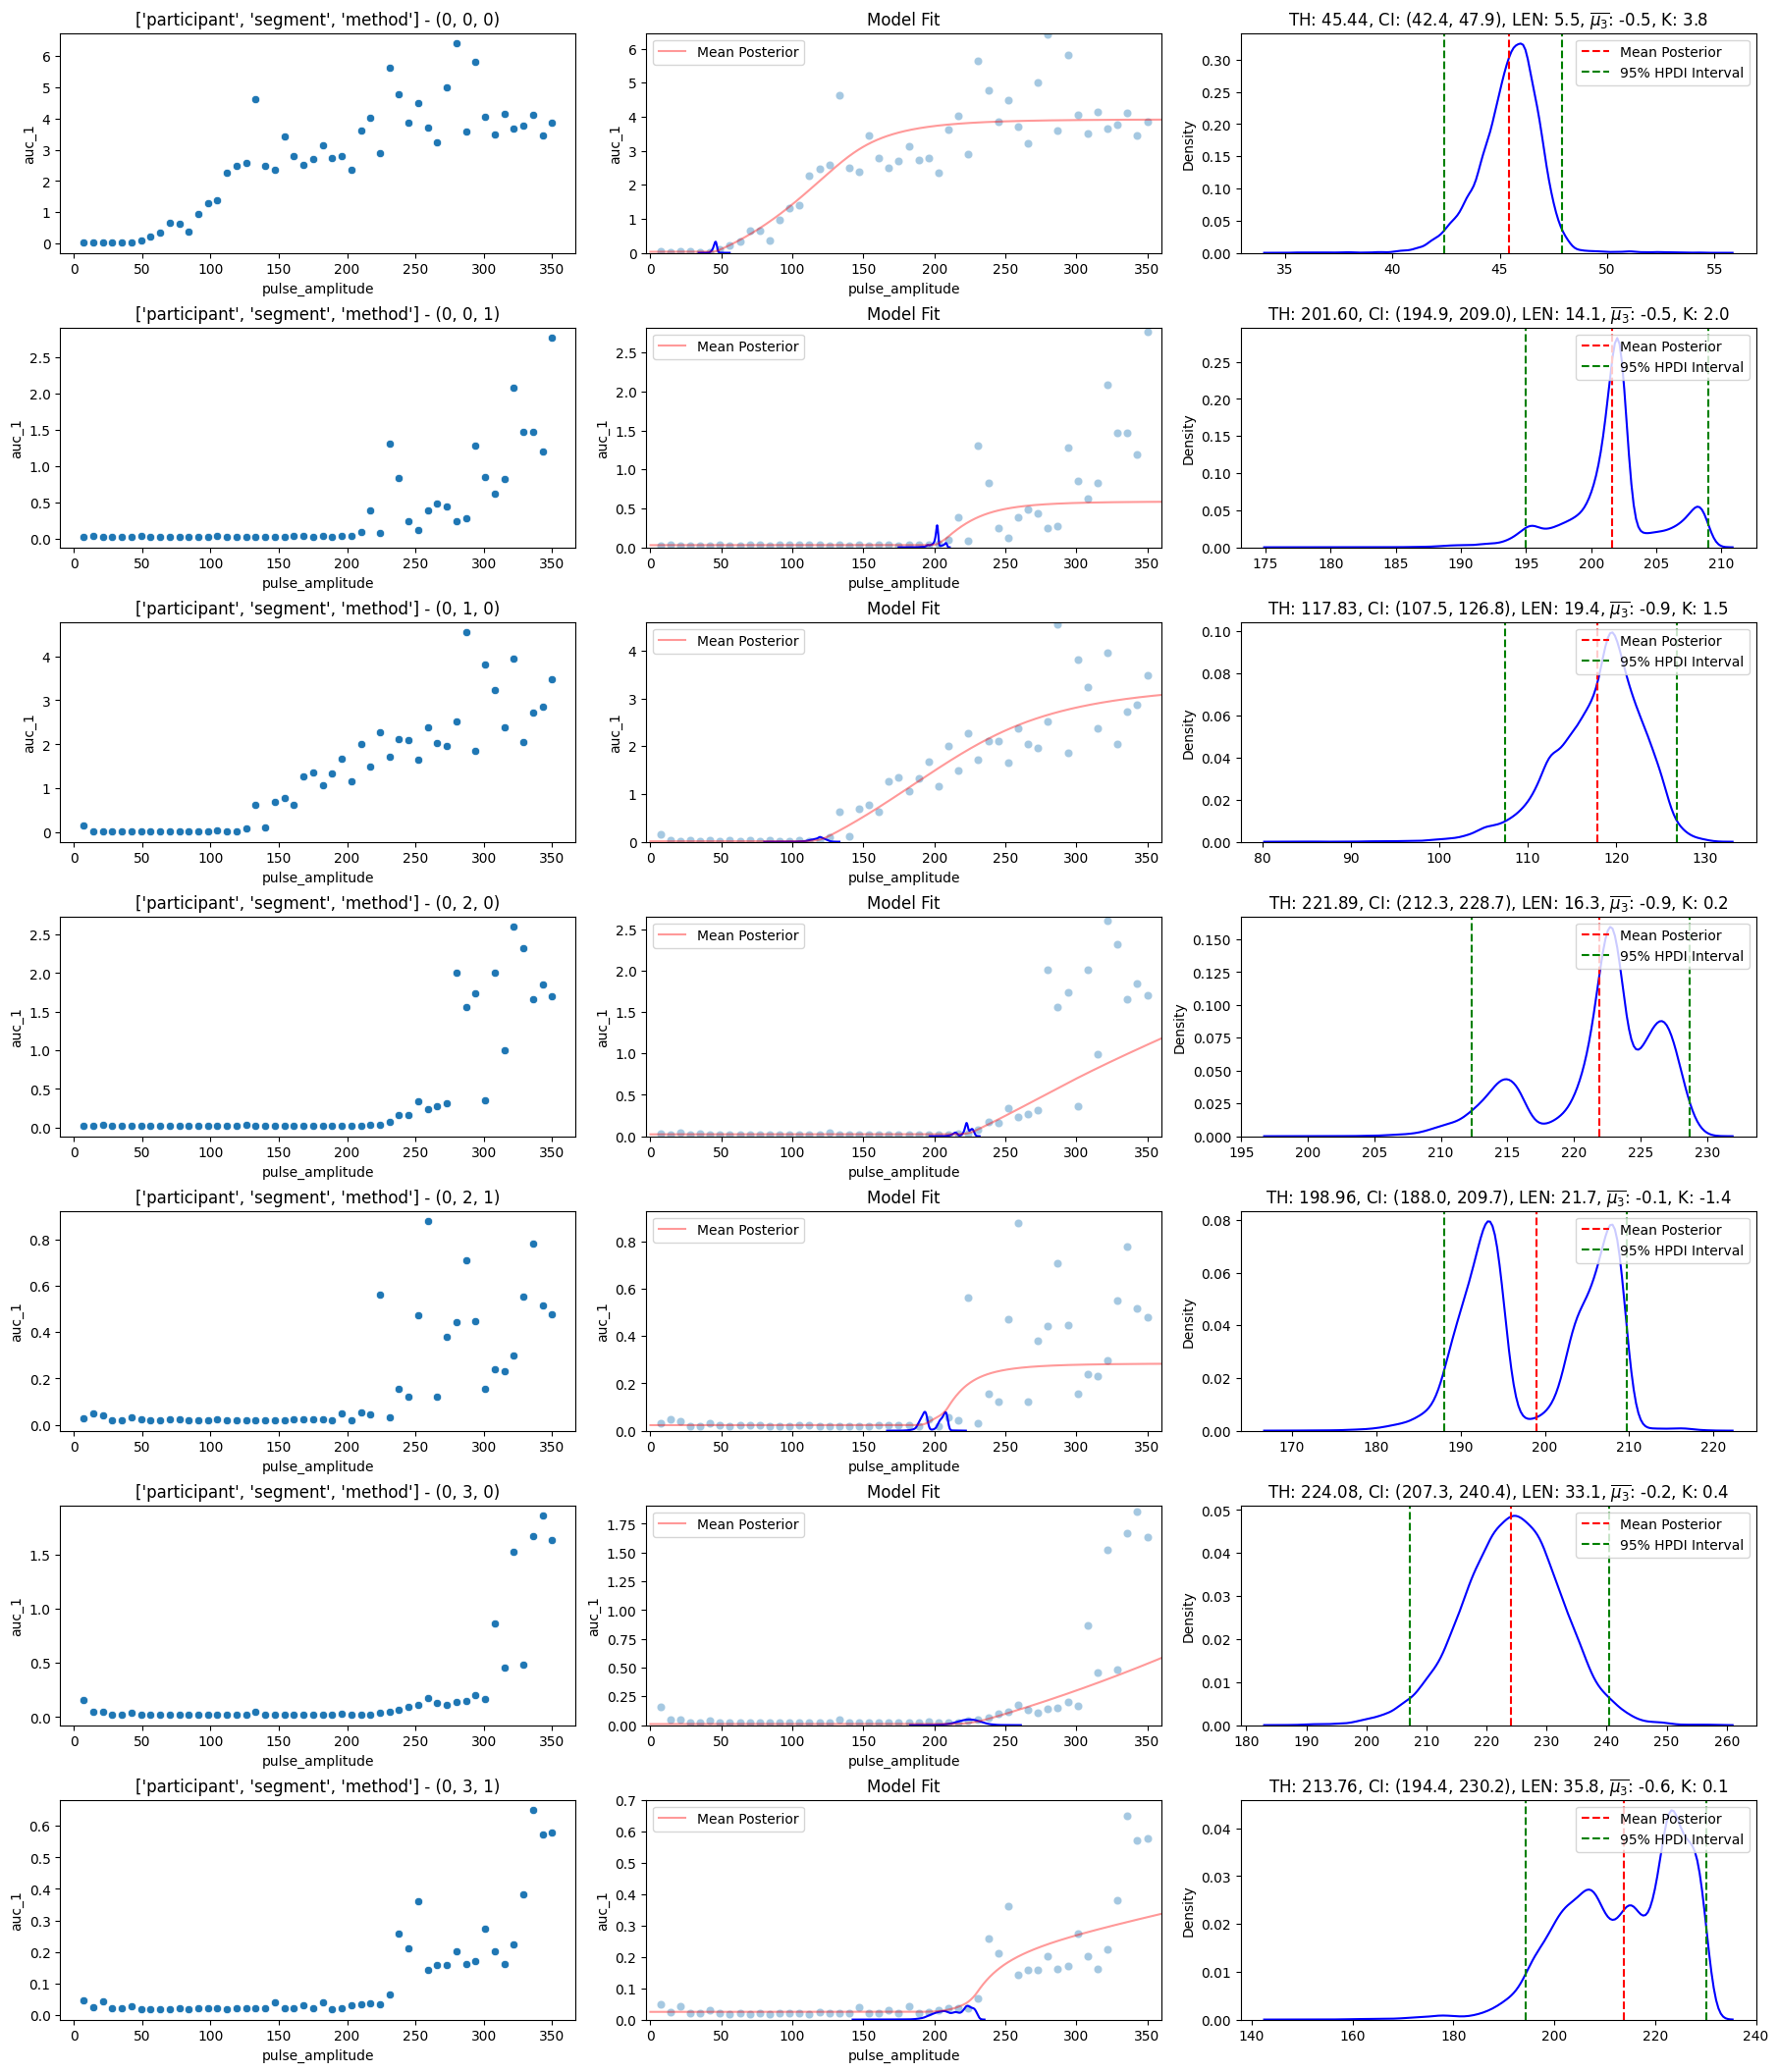

In [11]:
model.plot(df=df, posterior_samples=posterior_samples);

#### Information Criterion

In [12]:
numpyro_data = az.from_numpyro(mcmc)

##### Loo

In [11]:
az.loo(numpyro_data)

/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 24000 posterior samples and 357 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   519.41    22.27
p_loo       44.69        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      343   96.1%
 (0.5, 0.7]   (ok)         12    3.4%
   (0.7, 1]   (bad)         2    0.6%
   (1, Inf)   (very bad)    0    0.0%

##### WAIC

In [12]:
az.waic(numpyro_data)

/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 24000 posterior samples and 357 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   521.51    22.20
p_waic       42.59        -

There has been a warning during the calculation. Please check the results.